Notes for Chapter 3: https://d2l.ai/chapter_linear-regression/index.html 

### 3.1. Linear regression

#### 3.1.1. Basics

$\hat y = w_1 x_1 + \ldots + w_d x_d + b$

$\hat y = \textbf w^T \textbf x + b$

w is (2,1), x is (2,1) (only one observation)

It is often better to represent in matrix/vector form. 

$\hat {\textbf y} = \textbf {X}^T\textbf{w} + b$

$\hat {\textbf y} \in \mathbb{R}^{n\times 1}, \mathbf X \in \mathbb{R}^{n\times d}, \textbf w \in \mathbb{R}^{d\times 1}, b \in \mathbb{R}^{1\times 1}$, and $n$ is the number of observations, while $d$ is the number of features

#### 3.1.1.2. Loss function

$l^{(i)}(\textbf w, b) = \frac{1}{2}\left( \hat y ^{(i)} - y^{(i)}  \right)^2$

$L(\textbf w, b) = \frac{1}{n} \sum_{i=1}^n l^{(i)}(\textbf w, b) = \frac{1}{n} \sum_{i=1}^n  \frac{1}{2}\left( \textbf w^T \textbf x^{(i)} + b - y^{(i)}  \right)^2$

When training the model, we seek:

$\textbf w^*, b^* = \argmin_{\textbf w, b} L(\textbf w, b)$

#### 3.1.1.3. Analytic Solution

we can solve this by taking the bias into the parameter $\textbf w$ by appending a column of ones in the design matrix $\textbf W$. Our problem then is to minimize $||\textbf~y~-~\textbf{Xw}||^2$... this leads to solving: 

$$\textbf w^* = (\textbf{X}^T\textbf{X})^{-1} \textbf{X}^T \textbf{y}$$

#### 3.1.2. Vectorization for speed

In [1]:
# %matplotlib inline
import math
import time
import numpy as np
import tensorflow as tf
from d2l import tensorflow as d2l



this example shows how using the vectoriz functions is significantly faster than using a loop. 

In [2]:
n = 10000
a = tf.ones(n)
b = tf.ones(n)

In [3]:
c = tf.Variable(tf.zeros(n))
t = time.time()
for i in range(n):
    c[i].assign(a[i] + b[i])
f'{time.time() - t:.5f} sec'

'17.59671 sec'

In [4]:
t = time.time()
d = a + b
f'{time.time() - t:.5f} sec'

'0.00000 sec'

#### 3.1.3. Normal dist with squared loss

In [5]:
def normal(x, mu, sigma):
    p = 1 / math.sqrt(2 * math.pi * sigma**2)
    return p * np.exp(-0.5 * (x - mu)**2 / sigma**2)

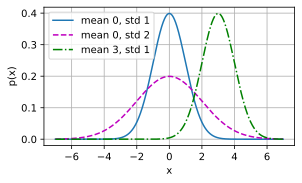

In [6]:
# Use NumPy again for visualization
x = np.arange(-7, 7, 0.01)

# Mean and standard deviation pairs
params = [(0, 1), (0, 2), (3, 1)]
d2l.plot(x, [normal(x, mu, sigma) for mu, sigma in params], xlabel='x',
         ylabel='p(x)', figsize=(4.5, 2.5),
         legend=[f'mean {mu}, std {sigma}' for mu, sigma in params])

### 3.2. Object oriented design

In [7]:
import time
import numpy as np
import tensorflow as tf
from d2l import tensorflow as d2l

In [8]:
def add_to_class(Class):  #@save
    """Register functions as methods in created class."""
    def wrapper(obj):
        setattr(Class, obj.__name__, obj)
    return wrapper

In [9]:
class A:
    def __init__(self):
        self.b = 1

a = A()

In [10]:
a.b

1

In [11]:
@add_to_class(A)
def do(self):
    print('Class attribute "b" is', self.b)

a.do()

Class attribute "b" is 1


In [12]:
class HyperParameters:  #@save
    """The base class of hyperparameters."""
    def save_hyperparameters(self, ignore=[]):
        raise NotImplemented

In [13]:
# Call the fully implemented HyperParameters class saved in d2l
class B(d2l.HyperParameters):
    def __init__(self, a, b, c):
        self.save_hyperparameters(ignore=['c'])
        print('self.a =', self.a, 'self.b =', self.b)
        print('There is no self.c =', not hasattr(self, 'c'))

b = B(a=1, b=2, c=3)

self.a = 1 self.b = 2
There is no self.c = True


In [14]:
class ProgressBoard(d2l.HyperParameters):  #@save
    """The board that plots data points in animation."""
    def __init__(self, xlabel=None, ylabel=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear',
                 ls=['-', '--', '-.', ':'], colors=['C0', 'C1', 'C2', 'C3'],
                 fig=None, axes=None, figsize=(3.5, 2.5), display=True):
        self.save_hyperparameters()

    def draw(self, x, y, label, every_n=1):
        raise NotImplemented

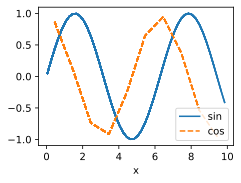

In [15]:
board = d2l.ProgressBoard('x')
for x in np.arange(0, 10, 0.1):
    board.draw(x, np.sin(x), 'sin', every_n=2)
    board.draw(x, np.cos(x), 'cos', every_n=10)

#### 3.2.2. Models

In [16]:
class Module(tf.keras.Model, d2l.HyperParameters):  #@save
    """The base class of models."""
    def __init__(self, plot_train_per_epoch=2, plot_valid_per_epoch=1):
        super().__init__()
        self.save_hyperparameters()
        self.board = ProgressBoard()
        self.training = None

    def loss(self, y_hat, y):
        raise NotImplementedError

    def forward(self, X):
        assert hasattr(self, 'net'), 'Neural network is defined'
        return self.net(X)

    def call(self, X, *args, **kwargs):
        if kwargs and "training" in kwargs:
            self.training = kwargs['training']
        return self.forward(X, *args)

    def plot(self, key, value, train):
        """Plot a point in animation."""
        assert hasattr(self, 'trainer'), 'Trainer is not inited'
        self.board.xlabel = 'epoch'
        if train:
            x = self.trainer.train_batch_idx / \
                self.trainer.num_train_batches
            n = self.trainer.num_train_batches / \
                self.plot_train_per_epoch
        else:
            x = self.trainer.epoch + 1
            n = self.trainer.num_val_batches / \
                self.plot_valid_per_epoch
        self.board.draw(x, value.numpy(), (
            'train_' if train else 'val_') + key, every_n=int(n))
    def training_step(self, batch):
        l = self.loss(self(*batch[:-1]), batch[-1])
        self.plot('loss', l, train=True)
        return l

    def validation_step(self, batch):
        l = self.loss(self(*batch[:-1]), batch[-1])
        self.plot('loss', l, train=False)

    def configure_optimizers(self):
        raise NotImplementedError

#### 3.2.3 Data

In [17]:
class DataModule(d2l.HyperParameters):  #@save
    """The base class of data."""
    def __init__(self, root='../data'):
        self.save_hyperparameters()

    def get_dataloader(self, train):
        raise NotImplementedError

    def train_dataloader(self):
        return self.get_dataloader(train=True)

    def val_dataloader(self):
        return self.get_dataloader(train=False)

#### 3.2.4. Training

In [18]:
class Trainer(d2l.HyperParameters):  #@save
    """The base class for training models with data."""
    def __init__(self, max_epochs, num_gpus=0, gradient_clip_val=0):
        self.save_hyperparameters()
        assert num_gpus == 0, 'No GPU support yet'

    def prepare_data(self, data):
        self.train_dataloader = data.train_dataloader()
        self.val_dataloader = data.val_dataloader()
        self.num_train_batches = len(self.train_dataloader)
        self.num_val_batches = (len(self.val_dataloader)
                                if self.val_dataloader is not None else 0)

    def prepare_model(self, model):
        model.trainer = self
        model.board.xlim = [0, self.max_epochs]
        self.model = model

    def fit(self, model, data):
        self.prepare_data(data)
        self.prepare_model(model)
        self.optim = model.configure_optimizers()
        self.epoch = 0
        self.train_batch_idx = 0
        self.val_batch_idx = 0
        for self.epoch in range(self.max_epochs):
            self.fit_epoch()

    def fit_epoch(self):
        raise NotImplementedError

## 3.3. Synthetic Regression data

In [19]:
%matplotlib inline
import random
import tensorflow as tf
from d2l import tensorflow as d2l

In [20]:
class SyntheticRegressionData(d2l.DataModule):  #@save
    def __init__(self, w, b, noise=0.01, num_train=1000, num_val=1000,
                 batch_size=32):
        super().__init__()
        self.save_hyperparameters()
        n = num_train + num_val
        self.X = tf.random.normal((n, w.shape[0]))
        noise = tf.random.normal((n, 1)) * noise
        self.y = tf.matmul(self.X, tf.reshape(w, (-1, 1))) + b + noise

In [21]:
data = SyntheticRegressionData(w=tf.constant([2, -3.4]), b = 4.2)

In [22]:
print('features:', data.X[0],'\nlabel:', data.y[0])

features: tf.Tensor([ 0.17409126 -2.4781415 ], shape=(2,), dtype=float32) 
label: tf.Tensor([12.962548], shape=(1,), dtype=float32)


#### 3.3.2. Reading the dataset

In [23]:
@d2l.add_to_class(SyntheticRegressionData)
def get_dataloader(self, train):
    if train:
        indices = list(range(0, self.num_train))
        # The examples are read in random order
        random.shuffle(indices)
    else:
        indices = list(range(self.num_train, self.num_train+self.num_val))
    for i in range(0, len(indices), self.batch_size):
        j = tf.constant(indices[i : i+self.batch_size])
        yield tf.gather(self.X, j), tf.gather(self.y, j)

In [24]:
X, y = next(iter(data.train_dataloader()))
print('X shape:', X.shape, '\ny shape:', y.shape)
print('features:', data.X[0],'\nlabel:', data.y[0])

X shape: (32, 2) 
y shape: (32, 1)
features: tf.Tensor([ 0.17409126 -2.4781415 ], shape=(2,), dtype=float32) 
label: tf.Tensor([12.962548], shape=(1,), dtype=float32)


#### 3.3.3. Concise Implementation of the Data Loader

In [25]:
@d2l.add_to_class(d2l.DataModule)  #@save
def get_tensorloader(self, tensors, train, indices=slice(0, None)):
    tensors = tuple(a[indices] for a in tensors)
    shuffle_buffer = tensors[0].shape[0] if train else 1
    return tf.data.Dataset.from_tensor_slices(tensors).shuffle(
        buffer_size=shuffle_buffer).batch(self.batch_size)

@d2l.add_to_class(SyntheticRegressionData)  #@save
def get_dataloader(self, train):
    i = slice(0, self.num_train) if train else slice(self.num_train, None)
    return self.get_tensorloader((self.X, self.y), train, i)

In [26]:
X, y = next(iter(data.train_dataloader()))
print('X shape:', X.shape, '\ny shape:', y.shape)

X shape: (32, 2) 
y shape: (32, 1)


In [27]:
len(data.train_dataloader())

32

## 3.4. Linear regression from scratch

In [28]:
%matplotlib inline
import tensorflow as tf
from d2l import tensorflow as d2l

In [29]:
class LinearRegressionScratch(d2l.Module):  #@save
    """The linear regression model implemented from scratch."""
    def __init__(self, num_inputs, lr, sigma=0.01):
        super().__init__()
        self.save_hyperparameters()
        w = tf.random.normal((num_inputs, 1), mean=0, stddev=0.01)
        b = tf.zeros(1)
        self.w = tf.Variable(w, trainable=True)
        self.b = tf.Variable(b, trainable=True)

In [30]:
@d2l.add_to_class(LinearRegressionScratch)  #@save
def forward(self, X):
    return tf.matmul(X, self.w) + self.b

In [31]:
@d2l.add_to_class(LinearRegressionScratch)  #@save
def loss(self, y_hat, y):
    l = (y_hat - y) ** 2 / 2
    return tf.reduce_mean(l)

In [32]:
class SGD(d2l.HyperParameters):  #@save
    """Minibatch stochastic gradient descent."""
    def __init__(self, lr):
        self.save_hyperparameters()

    def apply_gradients(self, grads_and_vars):
        for grad, param in grads_and_vars:
            param.assign_sub(self.lr * grad)

In [33]:
@d2l.add_to_class(LinearRegressionScratch)  #@save
def configure_optimizers(self):
    return SGD(self.lr)

### 3.4.4. Training

In [34]:
@d2l.add_to_class(d2l.Trainer)  #@save
def prepare_batch(self, batch):
    return batch

@d2l.add_to_class(d2l.Trainer)  #@save
def fit_epoch(self):
    self.model.training = True
    for batch in self.train_dataloader:
        with tf.GradientTape() as tape:
            loss = self.model.training_step(self.prepare_batch(batch))
        grads = tape.gradient(loss, self.model.trainable_variables)
        if self.gradient_clip_val > 0:
            grads = self.clip_gradients(self.gradient_clip_val, grads)
        self.optim.apply_gradients(zip(grads, self.model.trainable_variables))
        self.train_batch_idx += 1
    if self.val_dataloader is None:
        return
    self.model.training = False
    for batch in self.val_dataloader:
        self.model.validation_step(self.prepare_batch(batch))
        self.val_batch_idx += 1

error in estimating w: [ 0.00025952 -0.00019169]
error in estimating b: [0.00140572]


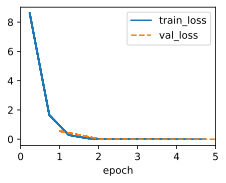

In [35]:
model = LinearRegressionScratch(2, lr=0.05)
data = d2l.SyntheticRegressionData(w=tf.constant([2, -3.4]), b=4.2)
trainer = d2l.Trainer(max_epochs=5)
trainer.fit(model, data)

print(f'error in estimating w: {data.w - tf.reshape(model.w, data.w.shape)}')
print(f'error in estimating b: {data.b - model.b}')

## 3.5 Concise Implementation of Linear Regression

In [36]:
import numpy as np
import tensorflow as tf
from d2l import tensorflow as d2l

In [37]:
class LinearRegression(d2l.Module):  #@save
    """The linear regression model implemented with high-level APIs."""
    def __init__(self, lr):
        super().__init__()
        self.save_hyperparameters()
        initializer = tf.initializers.RandomNormal(stddev=0.01)
        self.net = tf.keras.layers.Dense(1, kernel_initializer=initializer)

In [38]:
@d2l.add_to_class(LinearRegression)  #@save
def forward(self, X):
    return self.net(X)

### 3.5.2. Defining the loss function

In [39]:
@d2l.add_to_class(LinearRegression)  #@save
def loss(self, y_hat, y):
    fn = tf.keras.losses.MeanSquaredError()
    return fn(y, y_hat)

3.5.3. Defining the optimization algorithm

In [40]:
@d2l.add_to_class(LinearRegression)  #@save
def configure_optimizers(self):
    return tf.keras.optimizers.SGD(self.lr)

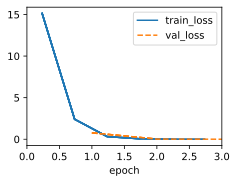

In [41]:
model = LinearRegression(lr=0.03)
data = d2l.SyntheticRegressionData(w=tf.constant([2, -3.4]), b=4.2)
trainer = d2l.Trainer(max_epochs=3)
trainer.fit(model, data)

In [42]:
@d2l.add_to_class(LinearRegression)  #@save
def get_w_b(self):
    return (self.get_weights()[0], self.get_weights()[1])

w, b = model.get_w_b()

In [43]:
w,b

(array([[ 1.9932393],
        [-3.3876514]], dtype=float32),
 array([4.189194], dtype=float32))

## 3.7 Weight Decay

In [46]:
%matplotlib inline
import tensorflow as tf
from d2l import tensorflow as d2l

#### 3.7.2. High dimensional linear regression

In [45]:
class Data(d2l.DataModule):
    def __init__(self, num_train, num_val, num_inputs, batch_size):
        self.save_hyperparameters()
        n = num_train + num_val
        self.X = tf.random.normal((n, num_inputs))
        noise = tf.random.normal((n, 1)) * 0.01
        w, b = tf.ones((num_inputs, 1)) * 0.01, 0.05
        self.y = tf.matmul(self.X, w) + b + noise

    def get_dataloader(self, train):
        i = slice(0, self.num_train) if train else slice(self.num_train, None)
        return self.get_tensorloader([self.X, self.y], train, i)

In [47]:
def l2_penalty(w):
    return tf.reduce_sum(w**2) / 2

In [48]:
class WeightDecayScratch(d2l.LinearRegressionScratch):
    def __init__(self, num_inputs, lambd, lr, sigma=0.01):
        super().__init__(num_inputs, lr, sigma)
        self.save_hyperparameters()

    def loss(self, y_hat, y):
        return (super().loss(y_hat, y) +
                self.lambd * l2_penalty(self.w))

In [49]:
data = Data(num_train=20, num_val=100, num_inputs=200, batch_size=5)
trainer = d2l.Trainer(max_epochs=10)

def train_scratch(lambd):
    model = WeightDecayScratch(num_inputs=200, lambd=lambd, lr=0.01)
    model.board.yscale='log'
    trainer.fit(model, data)
    print('L2 norm of w:', float(l2_penalty(model.w)))

L2 norm of w: 0.008865321055054665


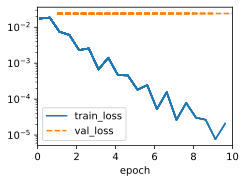

In [52]:
train_scratch(0)

L2 norm of w: 0.0014645548071712255


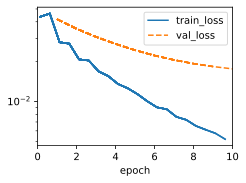

In [51]:
train_scratch(3)

L2 norm of w: 0.0005800282233394682


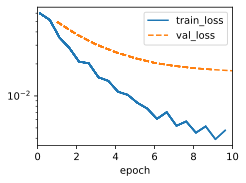

In [53]:
train_scratch(5)

3.7.4. Concise Implementation

In [54]:
class WeightDecay(d2l.LinearRegression):
    def __init__(self, wd, lr):
        super().__init__(lr)
        self.save_hyperparameters()
        self.net = tf.keras.layers.Dense(
            1, kernel_regularizer=tf.keras.regularizers.l2(wd),
            kernel_initializer=tf.keras.initializers.RandomNormal(0, 0.01)
        )

    def loss(self, y_hat, y):
        return super().loss(y_hat, y) + self.net.losses

L2 norm of w: 0.0006776948575861752


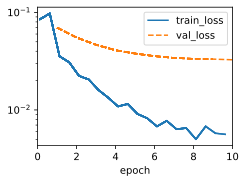

In [55]:
model = WeightDecay(wd=3, lr=0.01)
model.board.yscale='log'
trainer.fit(model, data)

print('L2 norm of w:', float(l2_penalty(model.get_w_b()[0])))